In [1]:
using LinearAlgebra, Parameters, Plots, BenchmarkTools
gr(fmt = :png); # save plots in .png

# Solving HJB for neoclassical growth models using implicit method

Presented by Chiyoung Ahn (@chiyahn) -- based on Ben Moll's notes in http://www.princeton.edu/~moll/HACTproject/HACT_Additional_Codes.pdf and  http://www.princeton.edu/~moll/HACTproject/HJB_NGM_implicit.m


# Setup

## Production function

In [2]:
A_productivity = 1.0
α = 0.3 
F(k) = A_productivity*k^α;

## Utility function

In [3]:
γ = 2.0
u(c) = c^(1-γ)/(1-γ) 
u_prime(c) = c^(-γ)

u_prime (generic function with 1 method)

## Law of motion

In [4]:
δ = 0.05
f(k, c) = F(k) - δ*k - c; # law of motion for state variable (saving)

## Consumption function by inverse

In [5]:
c(v_prime) = v_prime^(-1/γ); # consumption by derivative of value function at certain k

## Parameters and grids

In [6]:
# ρ: utility discount rate
# δ: capital discount rate
# γ: CRRA parameter
# F: production function that maps k to a real number
# u: utility function that maps c to a real number
# u_prime: derivative of utility function that maps c to a real number
# f: law of motion function that maps k (state), c (control) to the derivative of k
# c: consumption function that maps v_prime (derivative of v at certain k) to a real number
params = (ρ = 0.05, δ = δ, γ = γ, F = F, u = u, u_prime = u_prime, f = f, c = c)

(ρ = 0.05, δ = 0.05, γ = 2.0, F = F, u = u, u_prime = u_prime, f = f, c = c)

In [7]:
# ks: grids for states (k) -- assume uniform grids
# Δv: step size for iteration on v
# vs0: initial guess for vs
# maxit: maximum number of iterations
# threshold: threshold to be used for termination condition (maximum(abs.(vs-vs_new)) < threshold)
# verbose: boolean that ables/disables a verbose option
k_ss = (α*A_productivity/(params.ρ+params.δ))^(1/(1-α))
ks = range(0.001*k_ss, stop = 2*k_ss, length = 10000)
settings = (ks = ks,
            Δv = 1000, 
            vs0 = (A_productivity .* ks .^ α) .^ (1-params.γ) / (1-params.γ) / params.ρ,
            maxit = 100, threshold = 1e-8, verbose = false)

(ks = 0.0048039866566730914:0.0009604129739663476:9.607973313346182, Δv = 1000, vs0 = [-99.2086, -93.9299, -89.6863, -86.1654, -83.1746, -80.5873, -78.3161, -76.2986, -74.4886, -72.851  …  -10.1475, -10.1472, -10.1469, -10.1466, -10.1463, -10.1459, -10.1456, -10.1453, -10.145, -10.1447], maxit = 100, threshold = 1.0e-8, verbose = false)

# Solve

In [8]:
function compute_optimal_plans(params, settings)
    @unpack ρ, δ, γ, F, u, u_prime, f, c = params
    @unpack ks, Δv, vs0, maxit, threshold, verbose = settings

    P = length(ks)
    Δk = ks[2] - ks[1] # assume uniform grids

    # initial guess
    vs = vs0; 
    # save control (consumption) plan as well
    cs = zeros(P) 

    # begin iterations
    for n in 1:maxit
        dv = diff(vs) ./ Δk
        dv_f = [dv; NaN] # forward difference
        dv_b = [NaN; dv] # backward difference
        dv_0 = u_prime.(f.(ks, fill(0.0, P)))

        # define the corresponding drifts
        drift_f = f.(ks, c.(dv_f)) 
        drift_b = f.(ks, c.(dv_b))

        # steady states at boundary
        drift_f[end] = 0.0
        drift_b[1] = 0.0

        # compute consumptions and corresponding u(v)
        I_f = drift_f .> 0.0
        I_b = drift_b .< 0.0
        I_0 = 1 .- I_f-I_b

        dv_upwind = dv_f.*I_f + dv_b.*I_b + dv_0.*I_0;
        cs = c.(dv_upwind)
        us = u.(cs)

        # define the matrix A
        drift_f_upwind = max.(drift_f, 0.0) ./ Δk
        drift_b_upwind = min.(drift_b, 0.0) ./ Δk
        A = LinearAlgebra.Tridiagonal(-drift_b_upwind[2:P], 
                (-drift_f_upwind + drift_b_upwind), 
                drift_f_upwind[1:(P-1)]) 

        vs_new = (Diagonal(fill((ρ + 1/Δv), P)) - A) \ (us + vs ./ Δv)

        if (verbose)
            @show maximum(abs.(vs - vs_new))    
        end
        if (maximum(abs.(vs-vs_new)) < threshold)
            if (verbose)
               println("Value function converged -- total number of iterations: $n")
            end
            return (vs = vs, cs = cs)
            break
        end
        vs = vs_new
    end
    return (vs = vs, cs = cs) 
end

compute_optimal_plans (generic function with 1 method)

In [9]:
vs, cs = @btime compute_optimal_plans(params, settings)

  99.942 ms (3821380 allocations: 82.31 MiB)


(vs = [-24.2392, -24.1564, -24.0827, -24.0161, -23.9549, -23.8982, -23.8452, -23.7955, -23.7485, -23.7038  …  -12.8475, -12.8472, -12.8469, -12.8466, -12.8464, -12.8461, -12.8458, -12.8456, -12.8453, -12.845], cs = [0.107707, 0.114193, 0.120002, 0.125288, 0.130158, 0.134687, 0.13893, 0.142929, 0.146717, 0.150321  …  1.87668, 1.87677, 1.87686, 1.87695, 1.87704, 1.87713, 1.87722, 1.87731, 1.8774, 1.87749])

# Plots

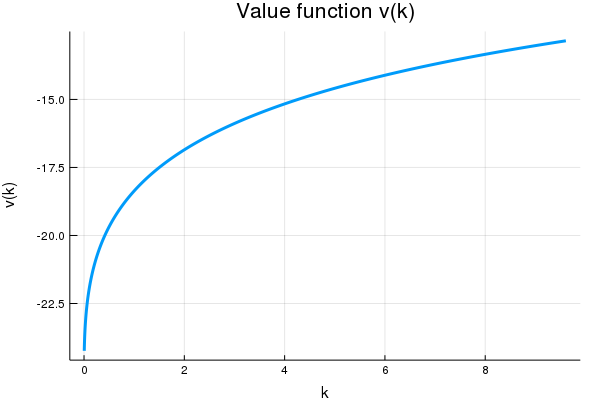

In [10]:
plot(ks, vs,
    linewidth = 3,
    title="Value function v(k)",xaxis="k",yaxis="v(k)",legend=false)

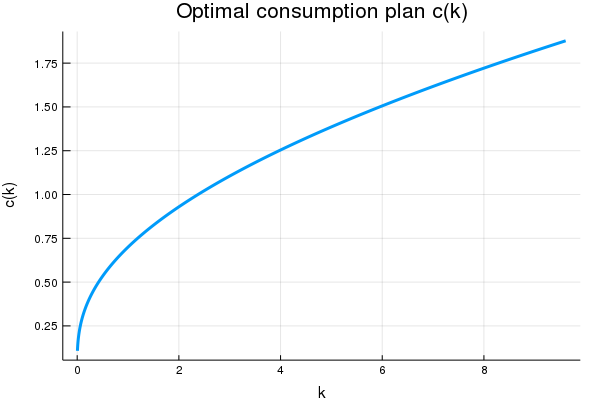

In [11]:
plot(ks, cs,
    lw = 3,
    title="Optimal consumption plan c(k)",xaxis="k",yaxis="c(k)",legend=false)

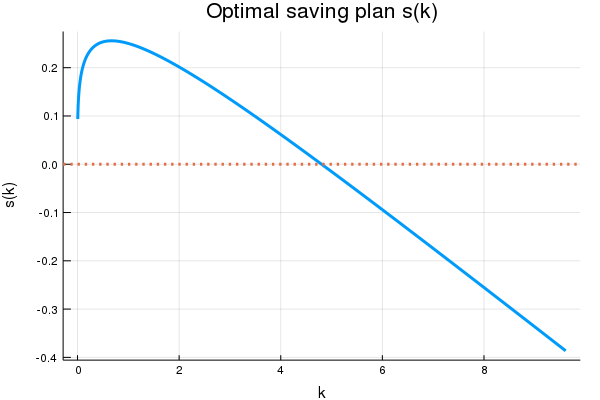

In [12]:
savings = f.(ks, cs) # Savings (states) according to optimal consumption plan
plot(ks, savings,
    linewidth = 3,
    title="Optimal saving plan s(k)",xaxis="k",yaxis="s(k)",legend=false)
plot!([.0], st = :hline, linestyle = :dot, lw = 3) # zero saving line